# Market Regime Classification

In [33]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay


In [34]:
# load datasets
df_bull = pd.read_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/btc_bull_merged.csv')
df_bear = pd.read_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/btc_bear_merged.csv')
df_side = pd.read_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/btc_side_merged.csv')

## Bull Market

In [ ]:
# Define forward-looking period and threshold
future_days = 5
threshold = 0.03  # 3% return

# Shift Close price N days forward
df_bull['future_close'] = df_bull['Close'].shift(-future_days)

# Calculate future return
df_bull['future_return'] = (df_bull['future_close'] - df_bull['Close']) / df_bull['Close']

# Define binary classification label
df_bull['future_trend'] = (df_bull['future_return'] > threshold).astype(int)

In [ ]:
# define features & target
features = [
    'Close', 'ema_7d', 'ema_20d', 'ema_30d',
    'sma_7d', 'sma_20d', 'sma_30d',
    'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26',
    'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d',
    'rsi_14d', 'atr_14d', 'fd_7d'
]


In [46]:
# bull market target
X_bull = df_bull[features]
y_bull = df_bull['future_trend']  # binary: 1 = uptrend next N days, 0 = else

In [37]:
# train & test datasets split
X_bull_train, X_bull_test, y_bull_train, y_bull_test = train_test_split(X_bull, y_bull, test_size=0.2, shuffle=False)

In [38]:
# model setup
model_bull = RandomForestClassifier(n_estimators=100, random_state=42)
model_bull.fit(X_bull_train, y_bull_train)

RandomForestClassifier(random_state=42)

In [41]:
# evaluation
y_bull_pred = model.predict(X_bull_test)
y_bull_proba = model.predict_proba(X_bull_test)[:,1]

print(confusion_matrix(y_bull_test, y_bull_pred))
print(classification_report(y_bull_test, y_bull_pred))
print(f"AUC Score: {roc_auc_score(y_bull_test, y_bull_proba):.4f}")

[[8 0]
 [8 3]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       1.00      0.27      0.43        11

    accuracy                           0.58        19
   macro avg       0.75      0.64      0.55        19
weighted avg       0.79      0.58      0.53        19

AUC Score: 0.9148


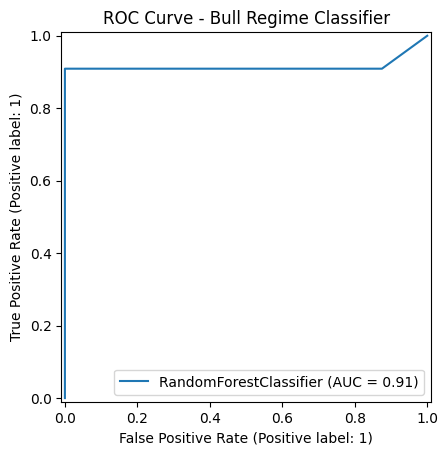

In [42]:
# plot ROC
RocCurveDisplay.from_estimator(model_bull, X_bull_test, y_bull_test)
plt.title('ROC Curve - Bull Regime Classifier')
plt.show()

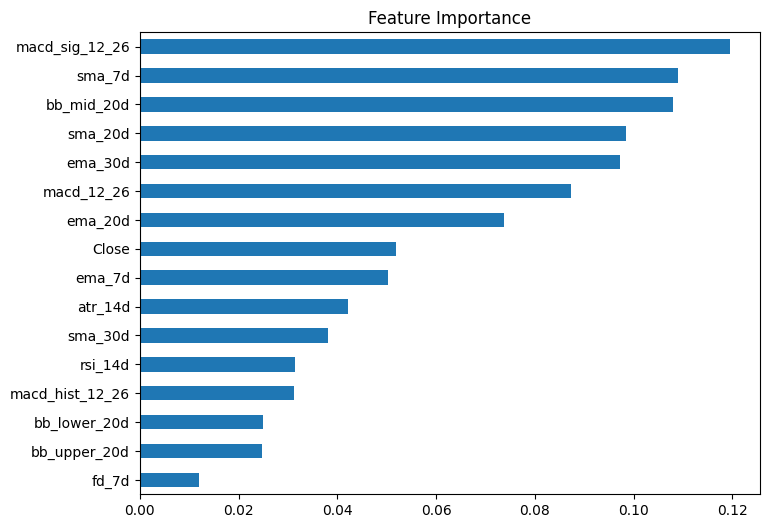

In [43]:
# feature importance
importances = pd.Series(model_bull.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(8, 6), title='Feature Importance')
plt.show()

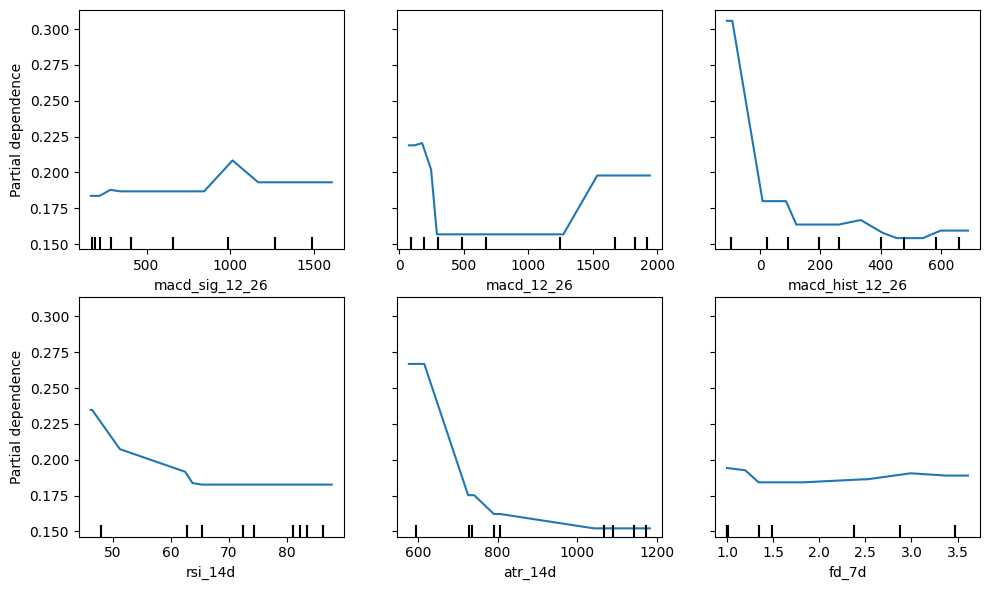

In [44]:
# Partial Dependence Plots (PDP)
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features_to_plot = ['macd_sig_12_26', 'macd_12_26', 'macd_hist_12_26', 'rsi_14d', 'atr_14d', 'fd_7d']

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    estimator=model_bull,        # trained classifier
    X=X_bull_test,             # test set
    features=features_to_plot,
    ax=ax
)
plt.tight_layout()
plt.show()


In [45]:
from sklearn.tree import export_text

# Show rules from the first tree
print(export_text(model_bull.estimators_[0], feature_names=list(X_bull.columns)))

|--- ema_20d <= 26488.90
|   |--- macd_hist_12_26 <= -130.09
|   |   |--- sma_20d <= 23261.02
|   |   |   |--- class: 1.0
|   |   |--- sma_20d >  23261.02
|   |   |   |--- class: 0.0
|   |--- macd_hist_12_26 >  -130.09
|   |   |--- rsi_14d <= 62.51
|   |   |   |--- class: 1.0
|   |   |--- rsi_14d >  62.51
|   |   |   |--- sma_30d <= 23487.39
|   |   |   |   |--- class: 1.0
|   |   |   |--- sma_30d >  23487.39
|   |   |   |   |--- class: 0.0
|--- ema_20d >  26488.90
|   |--- macd_hist_12_26 <= -27.44
|   |   |--- sma_20d <= 27014.99
|   |   |   |--- class: 0.0
|   |   |--- sma_20d >  27014.99
|   |   |   |--- class: 1.0
|   |--- macd_hist_12_26 >  -27.44
|   |   |--- class: 0.0



## Bear Market

In [62]:
# Define forward-looking period and threshold
future_days = 5
threshold = 0.02  # 2% down

# Shift Close price N days forward
df_bear['future_close'] = df_bear['Close'].shift(-future_days)

# Calculate future return
df_bear['future_return'] = (df_bear['future_close'] - df_bear['Close']) / df_bear['Close']

# Define binary classification label
df_bear['future_trend'] = (df_bear['future_return'] < -threshold).astype(int)

In [63]:
df_bear

,datetime,Unnamed: 0,Open,High,Low,BTC_Close,Volume,Close,ema_7d,ema_20d,...,bb_mid_20d,bb_upper_20d,bb_lower_20d,atr_14d,corr_7d,fd_7d,regime,future_close,future_return,future_trend
0,2023-05-01,120,29206.0,29306.8,27635.6,28042.8,0.597618,28042.8,28701.113013,28656.413494,...,28992.925,31092.674000,26893.176000,1088.033150,0.091836,2.165,bear,28865.7,0.029344,0
1,2023-05-02,121,28042.8,28858.5,27849.7,28643.2,0.394862,28643.2,28686.634760,28655.155066,...,28931.475,30996.342566,26866.607434,1082.373640,0.174940,2.381,bear,28435.2,-0.007262,0
2,2023-05-03,122,28643.4,29234.0,28098.6,28999.1,1.364508,28999.1,28764.751070,28687.911727,...,28862.795,30819.909974,26905.680026,1086.161237,0.287671,1.548,bear,27656.8,-0.046288,1
3,2023-05-04,123,28999.1,29336.5,28653.2,28817.7,0.851864,28817.7,28777.988302,28700.272515,...,28782.290,30602.985851,26961.594149,1057.385434,0.120691,2.000,bear,27611.2,-0.041867,1
4,2023-05-05,124,28818.3,29658.4,28798.6,29473.7,0.964647,29473.7,28951.916227,28773.932275,...,28741.485,30458.856675,27024.113325,1043.272189,-0.042344,2.735,bear,27583.0,-0.064149,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2023-08-27,238,25981.1,26141.8,25931.8,26066.3,0.019895,26066.3,26209.318547,27170.421308,...,27564.660,30762.733438,24366.586562,627.562388,NaN,3.116,bear,NaN,NaN,0
58,2023-08-28,239,26066.3,26212.6,25840.6,26075.8,0.064538,26075.8,26175.938910,27066.171660,...,27381.920,30480.174297,24283.665703,609.307931,0.570842,2.261,bear,NaN,NaN,0
59,2023-08-29,240,26077.8,28106.9,25881.7,27682.7,0.130353,27682.7,26552.629183,27124.888645,...,27289.090,30230.509059,24347.670941,724.728793,0.879465,2.245,bear,NaN,NaN,0
60,2023-08-30,241,27684.4,27732.1,27027.6,27267.3,0.014227,27267.3,26731.296887,27138.451631,...,27182.360,29959.711733,24405.008267,723.283880,0.896730,1.293,bear,NaN,NaN,0


In [64]:
# define features & target
features = [
    'Close', 'ema_7d', 'ema_20d', 'ema_30d',
    'sma_7d', 'sma_20d', 'sma_30d',
    'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26',
    'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d',
    'rsi_14d', 'atr_14d', 'fd_7d'
]

In [65]:
# bear market target
X_bear = df_bear[features]
y_bear = df_bear['future_trend']  # binary: 1 = downtrend next N days, 0 = else

In [72]:
# train & test datasets split
X_bear_train, X_bear_test, y_bear_train, y_bear_test = train_test_split(
    X_bear, y_bear,
    test_size=0.2,
    random_state=42,
    stratify=y_bear
)

In [73]:
# model setup
model_bear = RandomForestClassifier(n_estimators=100, random_state=42)
model_bear.fit(X_bear_train, y_bear_train)

RandomForestClassifier(random_state=42)

In [74]:
# evaluation
y_bear_pred = model.predict(X_bear_test)
y_bear_proba = model.predict_proba(X_bear_test)[:,1]

print(confusion_matrix(y_bear_test, y_bear_pred))
print(classification_report(y_bear_test, y_bear_pred))
print(f"AUC Score: {roc_auc_score(y_bear_test, y_bear_proba):.4f}")

[[9 0]
 [4 0]]
              precision    recall  f1-score   support

           0       0.69      1.00      0.82         9
           1       0.00      0.00      0.00         4

    accuracy                           0.69        13
   macro avg       0.35      0.50      0.41        13
weighted avg       0.48      0.69      0.57        13

AUC Score: 0.3750


/opt/anaconda3/envs/de_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/de_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/de_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


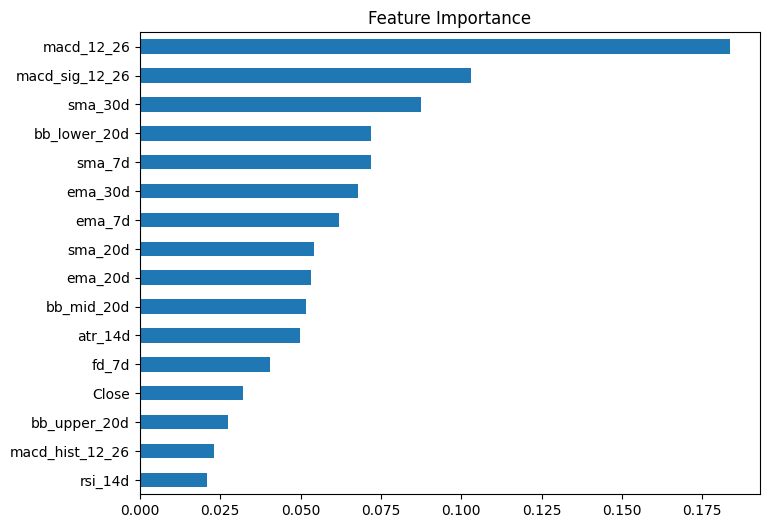

In [75]:
# feature importance
importances = pd.Series(model_bear.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(8, 6), title='Feature Importance')
plt.show()

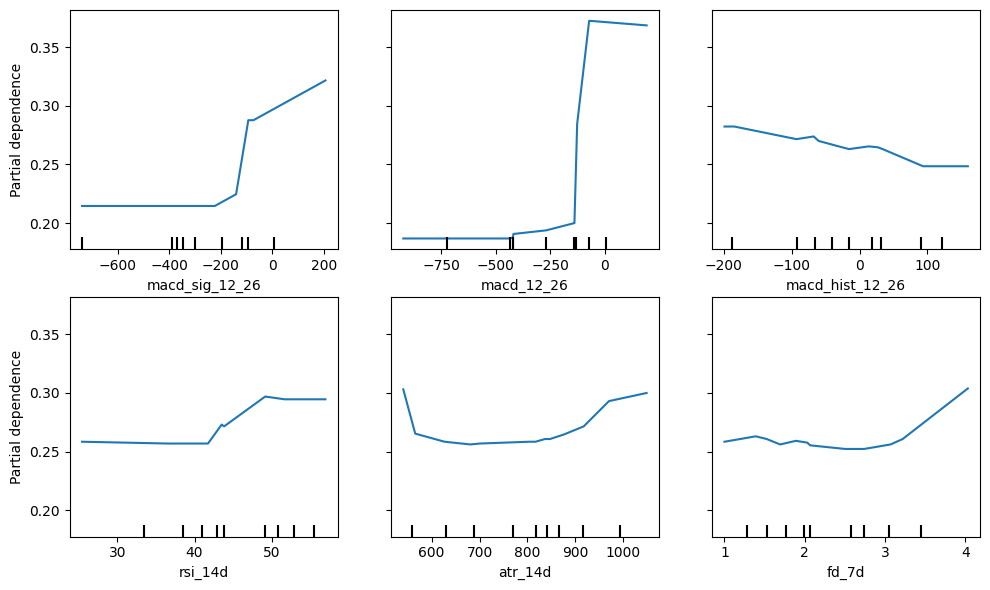

In [76]:
# Partial Dependence Plots (PDP)
features_to_plot = ['macd_sig_12_26', 'macd_12_26', 'macd_hist_12_26', 'rsi_14d', 'atr_14d', 'fd_7d']

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    estimator=model_bear,        # trained classifier
    X=X_bear_test,             # test set
    features=features_to_plot,
    ax=ax
)
plt.tight_layout()
plt.show()

In [77]:
from sklearn.tree import export_text

# Show rules from the first tree
print(export_text(model_bear.estimators_[0], feature_names=list(X_bear.columns)))

|--- ema_7d <= 28203.50
|   |--- sma_7d <= 26981.33
|   |   |--- sma_20d <= 28027.48
|   |   |   |--- class: 0.0
|   |   |--- sma_20d >  28027.48
|   |   |   |--- class: 1.0
|   |--- sma_7d >  26981.33
|   |   |--- class: 0.0
|--- ema_7d >  28203.50
|   |--- sma_20d <= 29318.57
|   |   |--- sma_30d <= 28827.84
|   |   |   |--- class: 0.0
|   |   |--- sma_30d >  28827.84
|   |   |   |--- class: 1.0
|   |--- sma_20d >  29318.57
|   |   |--- fd_7d <= 1.93
|   |   |   |--- class: 1.0
|   |   |--- fd_7d >  1.93
|   |   |   |--- class: 0.0



In [78]:
def run_classifier_strategy(df, model, features, future_days=5, initial_capital=10000):
    df = df.copy()

    # Preprocess input
    X = df[features].dropna()
    X_index = X.index

    # Predict future trend
    y_pred = model.predict(X)
    df.loc[X_index, 'predicted_signal'] = y_pred

    # Generate trading signals: Buy when signal == 1, Hold when signal == 0
    df['position'] = df['predicted_signal'].shift(1).fillna(0)

    # Simulate returns (assume enter at close, exit N days later)
    df['future_price'] = df['Close'].shift(-future_days)
    df['return'] = (df['future_price'] - df['Close']) / df['Close']

    # Apply position (binary 1 or 0) to returns
    df['strategy_return'] = df['position'] * df['return']

    # Compute equity curve
    df['strategy_cum_return'] = (1 + df['strategy_return'].fillna(0)).cumprod()
    df['portfolio_value'] = initial_capital * df['strategy_cum_return']

    return df

In [79]:
def evaluate_portfolio(df, initial_capital=10000):
    final_value = df['portfolio_value'].iloc[-1]
    net_profit = final_value - initial_capital
    total_return = net_profit / initial_capital
    daily_returns = df['strategy_return'].fillna(0)

    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    max_drawdown = ((df['portfolio_value'] / df['portfolio_value'].cummax()) - 1).min()

    print(f'Initial Capital      : ${initial_capital:,.2f}')
    print(f'Final Portfolio Value: ${final_value:,.2f}')
    print(f'Net Profit           : ${net_profit:,.2f}')
    print(f'Total Return         : {total_return:.2%}')
    print(f'Sharpe Ratio         : {sharpe_ratio:.2f}')
    print(f'Max Drawdown         : {max_drawdown:.2%}')

In [80]:
def plot_portfolio(df):
    plt.figure(figsize=(10, 5))
    df['portfolio_value'].plot()
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [83]:
def plot_portfolio_with_signals(df):
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['Close'], label='Close Price', linewidth=1.5)

    # Entry signals: where predicted_signal == 1
    buy_signals = df[(df['predicted_signal'] == 1) & (df['predicted_signal'].shift(1) != 1)]
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal')

    # Exit (future exit) - simplistic: where predicted_signal turns off
    sell_signals = df[(df['predicted_signal'] != 1) & (df['predicted_signal'].shift(1) == 1)]
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal')

    plt.title('BTC Price with Trade Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [81]:
df_btc = pd.read_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/BTC_ml_training.csv')

Initial Capital      : $10,000.00
Final Portfolio Value: $116,441.84
Net Profit           : $106,441.84
Total Return         : 1064.42%
Sharpe Ratio         : 3.23
Max Drawdown         : -24.88%


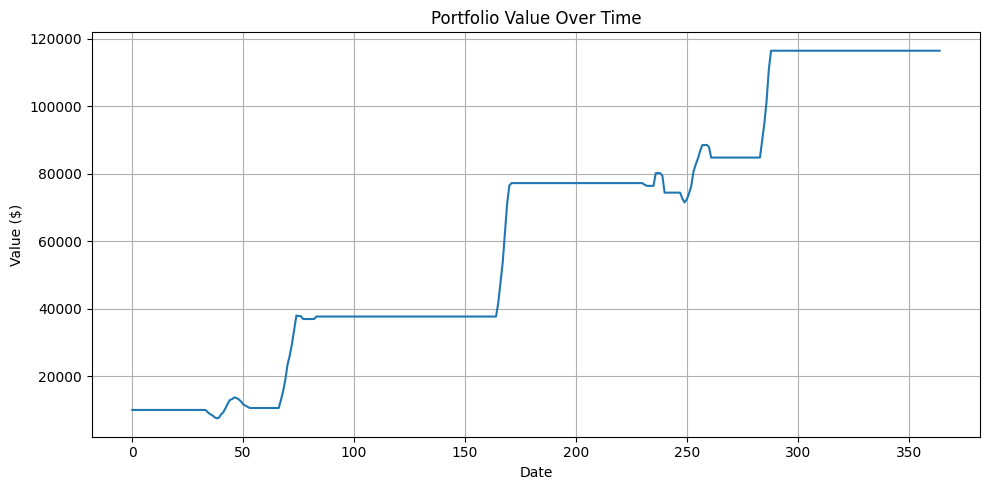

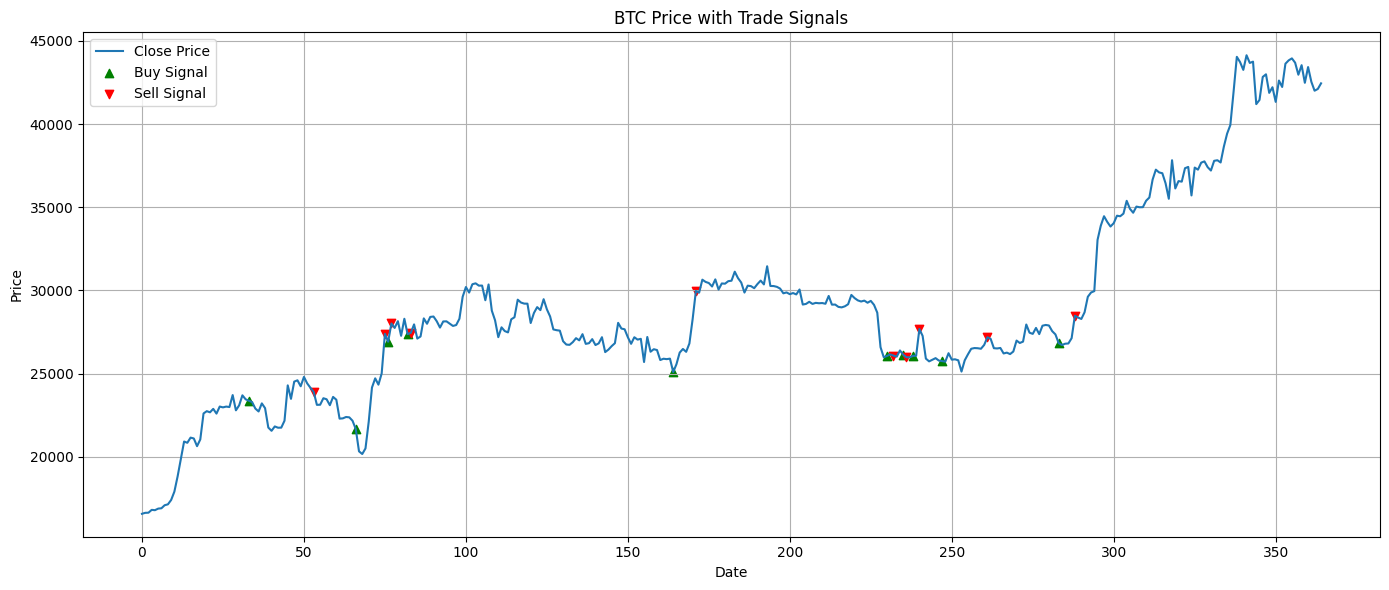

In [85]:
features = [
    'Close', 'ema_7d', 'ema_20d', 'ema_30d',
    'sma_7d', 'sma_20d', 'sma_30d',
    'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26',
    'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d',
    'rsi_14d', 'atr_14d', 'fd_7d'
]

df_result = run_classifier_strategy(df_btc, model_bull, features)
evaluate_portfolio(df_result)
plot_portfolio(df_result)
plot_portfolio_with_signals(df_result)